In [1]:
import pandas as pd
import geopandas as gpd
from datetime import datetime
import os
from dotenv import dotenv_values
import numpy as np
from rasterstats import zonal_stats
import rasterio as rio
from rasterio.session import AWSSession
import boto3

%matplotlib inline

    
# print current working directory
os.getcwd()

/Users/chasedawson/opt/anaconda3/envs/earth-analytics-python/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.9.1dev-CAPI-1.14.1) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


'/Users/chasedawson/dev/uva_equity_center/summer-sandbox/landsat8'

In [2]:
# read in Landsat 8 Collection 2 Level 2 Metadata
meta = pd.read_csv("https://landsat.usgs.gov/landsat/metadata_service/bulk_metadata_files/LANDSAT_OT_C2_L2.csv.gz", compression='gzip')

# add year column
meta['year'] = meta['Date Acquired'].apply(lambda x: datetime.strptime(x, '%Y/%m/%d').year)

# add month column
meta['month'] = meta['Date Acquired'].apply(lambda x: datetime.strptime(x, '%Y/%m/%d').month)

In [3]:
# read in wrs data
wrs_url = 'https://d9-wret.s3.us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/atoms/files/WRS2_descending_0.zip'
wrs = gpd.read_file(wrs_url, compression = 'zip')

<AxesSubplot:>

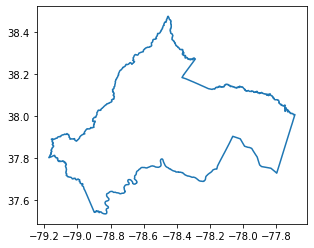

In [98]:
# read in cville spatial data 
cville_sp = {}
for sp in ['counties', 'tracts', 'blkgps', 'blocks']:
    gdf = gpd.read_file('../spatial_units/data/cville_{sp}.shp'.format(sp = sp))
    cville_sp[sp] = gdf

cville = cville_sp['counties'].dissolve()
cville_city = cville_sp['counties'][cville_sp['counties'].COUNTYFP == "540"]
cville.boundary.plot()

In [9]:
def select_scenes(scenes, region, wrs, months = [6, 7, 8, 9], year_range = (2017, 2022), max_cloud_cover = 10):
    """
    Selects scenes from bulk metadata that intersect with a provided region for desired year, months, and maximum cloud cover. Specifically,
    select_scenes will return all scenes that intersect with region where the year the scene was acquired is >= year_range[0] and <= year_range[1], the month the scene
    was acquired is listed in months, and the land cloud cover for the scene is <= max_cloud_cover. Also, select_scenes will only return scenes 
    captured during the day.

    Parameters
    ----------
    scenes: landsat8 c2 l2 scenes, read in / downloaded from USGS Bulk Metadata Tool (https://landsat.usgs.gov/landsat/metadata_service/bulk_metadata_files/LANDSAT_OT_C2_L2.csv.gz)
        DataFrame

    region: target area
        GeoDataFrame with Polygon geometry

    months: months in which you want to accept scenes
        list of integers (1 = Jan, 2 = Feb ... 12 = Dec) 

    year_range: inclusive range of years in which you want to accept scenes
        tuple, (min_year, max_year)

    max_cloud_cover: maximum land cloud cover permitted in a scene
        int

    Returns
    -------
    GeoDataFrame of selected scenes containing all metadata 
    """
    # intersect focus region with wrs geometries
    wrs_intersection = wrs[wrs.intersects(region.to_crs(wrs.crs).geometry[0])]

    # join wrs_intersection with scenes to add geometry info to metadata
    scenes = wrs_intersection[['PATH', 'ROW', 'geometry']].merge(scenes, left_on = ['PATH', 'ROW'], right_on = ['WRS Path', 'WRS Row']).drop(columns=['PATH', 'ROW'])

    # filter to scenes in year range
    scenes = scenes[(scenes.year >= year_range[0]) & (scenes.year <= year_range[1])]
    
    # filter to scenes from given months
    scenes = scenes[scenes.month.isin(months)]
    
    # filter to scenes captured during the day
    scenes = scenes[scenes['Day/Night Indicator'] == "DAY"]
    
    # filter to scenes with land cloud cover less than max cloud cover
    scenes = scenes[scenes['Land Cloud Cover'] <= max_cloud_cover]
    
    return scenes

# select scenes that intersect with any part of region boundary
intersects = select_scenes(meta, cville, wrs)

In [10]:
def assign_groups(scenes, geoms, num_scenes = 5):
    """
    Given a GeoDataFrame containing scene info and a GeoDataFrame containing target regions, assign_groups selects the top 5 scenes for each region and 
    creates a minimal list of all scenes to download. This method is useful to run after select_scenes to ensure that the smaller regions contained with the 
    broader boundary (such as the block groups within a county) are being intersected by scenes as well.

    Parameters
    ----------
    scenes:

    geoms:

    Returns
    -------
    groups: 

    """
    # left join geoms and scenes to get a GeoDataFrame where each geom has all scenes it intersects with
    geoms = geoms.to_crs(scenes.crs)
    scenes_sub = scenes[['Landsat Scene Identifier', 'Land Cloud Cover', 'Date Acquired', 'month', 'year', 'geometry']]
    geoms_sub = geoms[['GEOID', 'geometry']]
    left_sjoin = gpd.sjoin(geoms_sub, scenes_sub, how="left")

    # convert to regular DataFrame, drop geometry column
    join = pd.DataFrame(left_sjoin.drop(columns='geometry'))
    
    # sort by cloud cover, then geoid and year
    join = join.sort_values(by = ['Land Cloud Cover'], ascending = True)
    join = join.sort_values(by = ['GEOID', 'year'], ascending = False)

    # get top 5 scenes for each geoid
    groups = join.groupby('GEOID').head(num_scenes).reset_index(drop=True)
    groups = groups[['GEOID', 'Landsat Scene Identifier']]
    
    # return both the groups DataFrame and the list of unique scene ids
    return groups
    

In [7]:
# for each spatial group, get list of 5 best scenes for each geometry within the spatial group. 
# for example, after running this cell, groups['blocks'] is a DataFrame that matches GEOIDs (for blocks) 
# to Landsat Scene Identifiers and scene_ids['blocks'] contains a unique list of these scene identifiers

groups = {}
scene_ids = {}
for sp in ['counties', 'tracts', 'blkgps', 'blocks']:

    # get 5 best scenes for each geometry within a spatial region
    groups[sp] = assign_groups(intersects, cville_sp[sp])

    # get unique list of scene ids for each spatial region
    scene_ids[sp] = list(np.unique(groups[sp]["Landsat Scene Identifier"].values))

    # join groups with sp to get geometry column of block groups
    groups[sp] = cville_sp[sp][['GEOID', 'geometry']].merge(groups[sp], how='inner')


In [11]:
# method to get filename from the scene id
def sceneIdToFile(scenes, id):
    return scenes[scenes['Landsat Scene Identifier'] == id]['Display ID'].iloc[0] + "_ST_B10.TIF"

# returns url to access scene on the AWS S3 bucket
def sceneIdToS3Path(scenes, id):
    file = sceneIdToFile(scenes, id)
    scene = scenes[scenes['Landsat Scene Identifier'] == id]
    year = scene['year'].iloc[0]
    path = scene['WRS Path'].iloc[0]
    row = scene['WRS Row'].iloc[0]
    product = scene['Display ID'].iloc[0]
    return "s3://usgs-landsat/collection02/level-2/standard/oli-tirs/" + str(year) + "/" + str(path).zfill(3) + "/" + str(row).zfill(3) + "/" + str(product) + "/" + str(file)

In [12]:
def rescale(arr):
    MULTIPLICATIVE_SCALE_FACTOR = 0.00341802
    ADDITIVE_SCALE_FACTOR = 149
    return arr * MULTIPLICATIVE_SCALE_FACTOR + ADDITIVE_SCALE_FACTOR

def to_fahrenheit(arr):
    return (arr - 273.15) * 1.8 + 32

In [13]:
# get unique list of all scene ids regardless of spatial group
all_scene_ids = []
for sp in ['counties', 'tracts', 'blkgps', 'blocks']:
    all_scene_ids += scene_ids[sp]

all_scene_ids = list(np.unique(all_scene_ids))

In [14]:
# add spatial region col to groups and combine to one data frame
temp = gpd.GeoDataFrame()
for sp in ['counties', 'tracts', 'blkgps', 'blocks']:

    # add spatial region col
    groups[sp]['spatial_region'] = [sp] * len(groups[sp])

    # add to temp
    temp = pd.concat([temp, groups[sp]])

all_groups = temp.reset_index().drop(columns=['index'])

In [15]:
# get scene metadata for all scenes we will analyze
scenes = intersects[intersects['Landsat Scene Identifier'].isin(all_scene_ids)]
assert len(all_scene_ids) == len(scenes)

In [16]:
aws_env_path = './.aws_env'
aws_config = dotenv_values(aws_env_path)
aws_session = AWSSession(boto3.Session(aws_access_key_id=aws_config['AWS_ACCESS_KEY_ID'], aws_secret_access_key=aws_config['AWS_SECRET_ACCESS_KEY']), requester_pays=True)

In [17]:
stats = pd.DataFrame()
with rio.Env(aws_session):
    for scene_id in all_scene_ids:
        # get all census geometries that intersect with this scene regardless of spatial region
        scene_intersects = all_groups[all_groups['Landsat Scene Identifier'] == scene_id]

        # get s3 url to scene
        cog = sceneIdToS3Path(intersects, scene_id)
        print('opening ' + scene_id)

        # read scene tif
        with rio.open(cog) as src:
            print('computing raster stats')

            affine = src.transform
            nodata = src.profile['nodata']
            raster_data = src.read(1)

            # make sure focus region crs is the same as scene
            gdf = scene_intersects.to_crs(src.crs)

            # mask nodata in raster so not included in temperature calculation
            raster_data = np.ma.masked_array(raster_data, mask = (raster_data == nodata))

            # convert kelvin values to fahrenheit values
            raster_data = to_fahrenheit(rescale(raster_data))
             
            # un mask
            raster_data = raster_data.data
            
            # set any values less than or equal to 32 degrees fahrenheit to nodata
            raster_data[raster_data <= 32] = nodata

            # comupute zonal stats
            cur_stats = pd.DataFrame(zonal_stats(gdf, raster_data, affine=affine, stats = ['min', 'max', 'median', 'mean', 'count'], nodata=nodata))

            # add geoid and landsat scene identifier columns
            cur_stats['GEOID'] = gdf['GEOID'].values
            cur_stats['Landsat Scene Identifier'] = gdf['Landsat Scene Identifier'].values

            # concat
            stats = pd.concat([stats, cur_stats])

opening LC80150342021197LGN00
computing raster stats
opening LC80150342022152LGN00
computing raster stats
opening LC80160332020250LGN00
computing raster stats
opening LC80160332020266LGN00
computing raster stats
opening LC80160332021156LGN00
computing raster stats
opening LC80160332021204LGN00
computing raster stats
opening LC80160332021236LGN00
computing raster stats
opening LC80160342020250LGN00
computing raster stats
opening LC80160342020266LGN00
computing raster stats
opening LC80160342021156LGN00
computing raster stats
opening LC80160342021220LGN00
computing raster stats
opening LC80160342021236LGN00
computing raster stats


In [24]:
# remove rows where count = 0
stats = stats[stats['count'] > 0]

In [34]:
# https://www.statology.org/pandas-weighted-average/
def weighted_average(df, values, weights):
    d = df[values]
    w = df[weights]
    return (d * w).sum() / w.sum()

In [42]:
# computed weighted average of temperature columns where weights are the number of pixels intersected in the zonal stats operation
mean = stats.groupby('GEOID').apply(weighted_average, 'mean', 'count')
median = stats.groupby('GEOID').apply(weighted_average, 'median', 'count')
min_ = stats.groupby('GEOID').apply(weighted_average, 'min', 'count')
max_ = stats.groupby('GEOID').apply(weighted_average, 'max', 'count')

In [85]:
# combine series into dataframe
grp_stats = pd.concat([mean, median, min_, max_], axis = 1).rename(columns = {0: 'mean', 1: 'median', 2: 'min', 3: 'max'}).reset_index()

In [88]:
grp_stats = grp_stats.merge(all_groups[["GEOID", "spatial_region"]].drop_duplicates(), on="GEOID", how='inner')

In [97]:
# write to csv
for sp in ['counties', 'tracts', 'blkgps', 'blocks']:
    grp_stats[grp_stats['spatial_region'] == sp].to_csv(f'landsat8_cville_{sp}.csv')